In [131]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import GCNConv, GATConv
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm
import numpy as np
import time

import matplotlib.pyplot as plt

os.environ['PYTORCH_MPS_ENABLE_FALLBACK']='1'

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [132]:

# Function to plot training and validation loss over epochs
def plot_loss(train_losses, val_losses, save_path='loss_plot.png'):
    """
    Plots the training and validation loss over epochs.

    Args:
        train_losses (list): List of training losses.
        val_losses (list): List of validation losses.
        save_path (str): Path to save the plot image.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()
    print(f"Loss plot saved to {save_path}")


In [133]:

def preprocess_data(filepath, sample_size=10000, k=10, random_state=42):
    """
    Load the dataset, sample a subset, encode categorical features,
    normalize continuous features, and create an optimized edge list.

    Args:
        filepath (str): Path to the CSV dataset.
        sample_size (int): Number of samples to select.
        k (int): Number of neighbors to connect for each node.
        random_state (int): Seed for reproducibility.

    Returns:
        Data: PyTorch Geometric Data object with sampled data.
        dict: Encoders used for categorical features.
    """
    print("Loading dataset...")
    # Load dataset
    df = pd.read_csv(filepath)
    print(f"Original dataset size: {df.shape}")

    # Sample the dataset
    print("Sampling data...")
    if sample_size < len(df):
        df_sampled = df.sample(n=sample_size, random_state=random_state).reset_index(drop=True)
    else:
        df_sampled = df.reset_index(drop=True)
    print(f"Sampled dataset size: {df_sampled.shape}")

    # Encode categorical features
    print("Encoding categorical features...")
    encoders = {}
    categorical_cols = ['disease_family', 'disease', 'smoking_status', 'cough_type']
    for col in categorical_cols:
        if col in df_sampled.columns:
            encoder = LabelEncoder()
            df_sampled[col] = encoder.fit_transform(df_sampled[col])
            encoders[col] = encoder
            print(f"Encoded column: {col}")
        else:
            raise ValueError(f"Column '{col}' not found in the dataset.")

    # Normalize continuous features
    print("Normalizing continuous features...")
    scaler = StandardScaler()
    continuous_cols = ['systolic_bp', 'diastolic_bp', 'cholesterol', 'BMI', 'heart_rate', 'blood_glucose']
    for col in continuous_cols:
        if col in df_sampled.columns:
            df_sampled[col] = scaler.fit_transform(df_sampled[[col]])
            print(f"Normalized column: {col}")
        else:
            raise ValueError(f"Column '{col}' not found in the dataset.")

    # Prepare node features (X)
    print("Preparing node features...")
    if 'patient_id' in df_sampled.columns:
        feature_cols = [col for col in df_sampled.columns if col != 'patient_id']
        x = torch.tensor(df_sampled[feature_cols].values, dtype=torch.float)
    else:
        x = torch.tensor(df_sampled.values, dtype=torch.float)
    print(f"Node features shape: {x.shape}")

    # Create optimized edge list
    print("Creating edge list...")
    edge_index = create_edge_list_vectorized(df_sampled, k=k)
    print(f"Edge list created with shape: {edge_index.shape}")

    return Data(x=x, edge_index=edge_index), encoders


In [134]:

def create_edge_list_vectorized(df, k=10):
    """
    Optimized edge list creation using vectorized operations.
    Connect each node to k randomly selected neighbors within the same 'disease_family'.

    Args:
        df (pd.DataFrame): Sampled DataFrame.
        k (int): Number of neighbors to connect for each node.

    Returns:
        torch.Tensor: Edge index tensor of shape [2, num_edges].
    """
    print("Grouping data by 'disease_family'...")
    edges = []

    groups = df.groupby('disease_family').groups
    print(f"Number of disease families: {len(groups)}")

    for group_name, group in tqdm(groups.items(), total=len(groups), desc="Processing groups"):
        group_indices = group.values  # Assuming group is a pandas Index or similar
        num_nodes = len(group_indices)

        if num_nodes <= 1:
            print(f"Group '{group_name}' has only {num_nodes} node(s). Skipping.")
            continue  # No edges can be formed

        # Determine the actual number of neighbors
        actual_k = min(k, num_nodes - 1)

        # Shuffle the indices for randomness
        shuffled_indices = np.random.permutation(group_indices)

        # Assign the first 'actual_k' indices as neighbors
        neighbors = np.tile(shuffled_indices[:actual_k], (num_nodes, 1))

        # Create source and target edges
        source_nodes = np.repeat(group_indices, actual_k)
        target_nodes = neighbors.flatten()

        # Append to the edge list
        edges.extend(zip(source_nodes, target_nodes))

    # Convert to NumPy array for efficient processing
    edges = np.array(edges)

    print("Removing duplicate edges and self-loops...")
    # Remove self-loops
    mask = edges[:, 0] != edges[:, 1]
    edges = edges[mask]

    # Remove duplicate edges
    edges = np.unique(edges, axis=0)
    print(f"Total edges after sampling: {len(edges)}")

    if len(edges) == 0:
        raise ValueError("No edges were created. Please check the edge creation logic.")

    # Convert to PyTorch tensor
    edge_index = torch.tensor(edges, dtype=torch.long).t()

    return edge_index


In [135]:
class PatientGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super(PatientGNN, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.attention = GATConv(hidden_channels, hidden_channels, heads=heads, concat=False)
        self.gcn2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = torch.relu(x)
        x = self.attention(x, edge_index)
        x = torch.relu(x)
        x = self.gcn2(x, edge_index)
        return x


In [136]:
def train(model, optimizer, criterion, data, device, batch_size=64):
    model.train()
    optimizer.zero_grad()
    
    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)
    mini_batches = indices.split(batch_size)
    
    total_loss = 0
    bce_loss = torch.nn.BCEWithLogitsLoss()  # Use BCE with logits for numerical stability
    
    for batch in mini_batches:
        x_batch = data.x[batch].to(device)
        global_to_local = {global_idx.item(): local_idx for local_idx, global_idx in enumerate(batch)}
        
        # Filter and remap edges (same as before)
        mask_pos = torch.isin(data.train_pos_edge_index[0], batch) & torch.isin(data.train_pos_edge_index[1], batch)
        pos_edge_index_batch = data.train_pos_edge_index[:, mask_pos].to(device)
        pos_edge_index_batch = torch.tensor(
            [[global_to_local[node.item()] for node in pos_edge_index_batch_row]
             for pos_edge_index_batch_row in pos_edge_index_batch],
            dtype=torch.long,
            device=device,
        )
        
        mask_neg = torch.isin(data.train_neg_edge_index[0], batch) & torch.isin(data.train_neg_edge_index[1], batch)
        neg_edge_index_batch = data.train_neg_edge_index[:, mask_neg].to(device)
        neg_edge_index_batch = torch.tensor(
            [[global_to_local[node.item()] for node in neg_edge_index_batch_row]
             for neg_edge_index_batch_row in neg_edge_index_batch],
            dtype=torch.long,
            device=device,
        )
        
        out = model(x_batch, pos_edge_index_batch)
        
        # Compute positive and negative scores
        pos_src, pos_dst = pos_edge_index_batch
        neg_src, neg_dst = neg_edge_index_batch
        
        pos_out_src = out[pos_src]
        pos_out_dst = out[pos_dst]
        neg_out_src = out[neg_src]
        neg_out_dst = out[neg_dst]
        
        pos_scores = (pos_out_src * pos_out_dst).sum(dim=-1)  # Raw logits for BCE
        neg_scores = (neg_out_src * neg_out_dst).sum(dim=-1)  # Raw logits for BCE
        
        # Combine positive and negative samples for BCE
        scores = torch.cat([pos_scores, neg_scores], dim=0)
        labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)], dim=0)
        
        # Compute BCE Loss
        loss = bce_loss(scores, labels)
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        optimizer.zero_grad()
    
    return total_loss / len(mini_batches)


In [137]:

# Evaluation Function
def evaluate(model, criterion, data, split='val'):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.train_pos_edge_index)

        if split == 'val':
            pos_edge = data.val_pos_edge_index
            neg_edge = data.val_neg_edge_index
        elif split == 'test':
            pos_edge = data.test_pos_edge_index
            neg_edge = data.test_neg_edge_index
        else:
            raise ValueError("Split must be 'val' or 'test'")

        pos_src = pos_edge[0]
        pos_dst = pos_edge[1]
        neg_src = neg_edge[0]
        neg_dst = neg_edge[1]

        pos_out_src = out[pos_src]
        pos_out_dst = out[pos_dst]
        neg_out_src = out[neg_src]
        neg_out_dst = out[neg_dst]

        # Compute similarity scores
        pos_scores = (pos_out_src * pos_out_dst).sum(dim=-1)
        neg_scores = (neg_out_src * neg_out_dst).sum(dim=-1)

        # Compute loss
        pos_loss = -torch.log(torch.sigmoid(pos_scores) + 1e-15).mean()
        neg_loss = -torch.log(1 - torch.sigmoid(neg_scores) + 1e-15).mean()
        loss = pos_loss + neg_loss

    return loss.item()


In [138]:

# Recommendation Function
def recommend_similar_patients(model, data, patient_id, top_k=5):
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x, data.train_pos_edge_index)
        embeddings = embeddings.cpu()  # Ensure embeddings are on CPU
        patient_embedding = embeddings[patient_id].unsqueeze(0)
        similarities = torch.cosine_similarity(patient_embedding, embeddings)
        recommended_patients = similarities.argsort(descending=True)[1:top_k+1]
        return recommended_patients


In [139]:

# Function to split edges into train, val, test
def split_edges(data, val_ratio=0.05, test_ratio=0.05, random_state=42):
    """
    Split the edges in data.edge_index into train, validation, and test sets.

    Args:
        data (Data): PyTorch Geometric Data object.
        val_ratio (float): Proportion of edges to use for validation.
        test_ratio (float): Proportion of edges to use for testing.
        random_state (int): Seed for reproducibility.

    Returns:
        Data: Data object with train, val, and test edge indices.
    """
    print("Splitting edges into train, validation, and test sets...")
    num_edges = data.edge_index.size(1)
    num_val = int(num_edges * val_ratio)
    num_test = int(num_edges * test_ratio)
    num_train = num_edges - num_val - num_test

    # Shuffle edge indices with reproducibility
    generator = torch.Generator().manual_seed(random_state)
    indices = torch.randperm(num_edges, generator=generator)
    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_val]
    test_indices = indices[num_train + num_val:]

    data.train_pos_edge_index = data.edge_index[:, train_indices]
    data.val_pos_edge_index = data.edge_index[:, val_indices]
    data.test_pos_edge_index = data.edge_index[:, test_indices]

    # Generate negative samples for train, val, and test
    print("Generating negative samples for training...")
    data.train_neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1),
        method='sparse'
    )

    print("Generating negative samples for validation...")
    data.val_neg_edge_index = negative_sampling(
        edge_index=data.val_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.val_pos_edge_index.size(1),
        method='sparse'
    )

    print("Generating negative samples for testing...")
    data.test_neg_edge_index = negative_sampling(
        edge_index=data.test_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.test_pos_edge_index.size(1),
        method='sparse'
    )

    return data


In [140]:

# Main Execution

# Filepath to dataset
filepath = 'datasets/SynDisNet.csv'  # Update this path as needed

# Set device to CUDA if available, else MPS or CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # device = torch.device("mps") - currently not supported
    device = torch.device("cpu")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


Using device: cpu


In [141]:
# Preprocess data and create Data object with sampling
sample_size = 64000  # Number of samples to select
k = 10  # Number of neighbors per node
data, encoders = preprocess_data(filepath, sample_size=sample_size, k=k)

# Split edges into train, val, and test
data = split_edges(data, val_ratio=0.1, test_ratio=0.1, random_state=42)
print("Edge splits:")
print(f"Train edges: {data.train_pos_edge_index.size(1)}")
print(f"Validation edges: {data.val_pos_edge_index.size(1)}")
print(f"Test edges: {data.test_pos_edge_index.size(1)}")

# Move data to device
print("Moving data to device...")
data = data.to(device)


Loading dataset...
Original dataset size: (1000000, 13)
Sampling data...
Sampled dataset size: (64000, 13)
Encoding categorical features...
Encoded column: disease_family
Encoded column: disease
Encoded column: smoking_status
Encoded column: cough_type
Normalizing continuous features...
Normalized column: systolic_bp
Normalized column: diastolic_bp
Normalized column: cholesterol
Normalized column: BMI
Normalized column: heart_rate
Normalized column: blood_glucose
Preparing node features...
Node features shape: torch.Size([64000, 12])
Creating edge list...
Grouping data by 'disease_family'...
Number of disease families: 10


Processing groups: 100%|██████████| 10/10 [00:00<00:00, 103.58it/s]


Removing duplicate edges and self-loops...
Total edges after sampling: 639900
Edge list created with shape: torch.Size([2, 639900])
Splitting edges into train, validation, and test sets...
Generating negative samples for training...
Generating negative samples for validation...
Generating negative samples for testing...
Edge splits:
Train edges: 511920
Validation edges: 63990
Test edges: 63990
Moving data to device...


In [142]:


# Initialize model and move to device
in_channels = data.x.size(1)
hidden_channels = 64
out_channels = 32
heads = 4
print("Initializing model...")
model = PatientGNN(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, heads=heads)
model = model.to(device)

Initializing model...


In [143]:


# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Alternatively, use a different loss based on your task

# Training loop with progress bar
epochs = 100
best_val_loss = float('inf')
patience = 20000
counter = 0


In [144]:

# Lists to store loss values for plotting
train_losses = []
val_losses = []


In [145]:
print("Starting training...")
for epoch in tqdm(range(epochs), desc="Training Progress", unit="epoch"):
    loss = train(model, optimizer, criterion, data, device=device, batch_size=2048)

    train_losses.append(loss)

    # Evaluate on validation set
    val_loss = evaluate(model, criterion, data, split='val')
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1

    if epoch % 10 == 0:
        print(f"raw loss: {loss}")
        print(f"Epoch {epoch}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if counter >= patience:
        print("Early stopping triggered.")
        break


Starting training...


Training Progress:   1%|          | 1/100 [00:04<07:43,  4.68s/epoch]

raw loss: 0.7616280261427164
Epoch 0, Train Loss: 0.7616, Val Loss: 0.7825


Training Progress:  11%|█         | 11/100 [00:47<06:37,  4.46s/epoch]

raw loss: 0.39531600708141923
Epoch 10, Train Loss: 0.3953, Val Loss: 0.7564


Training Progress:  21%|██        | 21/100 [01:35<06:19,  4.80s/epoch]

raw loss: 0.3847620775923133
Epoch 20, Train Loss: 0.3848, Val Loss: 0.7482


Training Progress:  31%|███       | 31/100 [02:27<06:00,  5.23s/epoch]

raw loss: 0.3859943295828998
Epoch 30, Train Loss: 0.3860, Val Loss: 0.7664


Training Progress:  41%|████      | 41/100 [03:19<05:11,  5.28s/epoch]

raw loss: 0.4092153627425432
Epoch 40, Train Loss: 0.4092, Val Loss: 0.7390


Training Progress:  51%|█████     | 51/100 [04:13<04:18,  5.28s/epoch]

raw loss: 0.39755585230886936
Epoch 50, Train Loss: 0.3976, Val Loss: 0.7382


Training Progress:  61%|██████    | 61/100 [05:08<03:38,  5.62s/epoch]

raw loss: 0.3936435501091182
Epoch 60, Train Loss: 0.3936, Val Loss: 0.7412


Training Progress:  71%|███████   | 71/100 [06:05<02:44,  5.68s/epoch]

raw loss: 0.39850413240492344
Epoch 70, Train Loss: 0.3985, Val Loss: 0.7407


Training Progress:  81%|████████  | 81/100 [07:04<01:52,  5.93s/epoch]

raw loss: 0.382466365583241
Epoch 80, Train Loss: 0.3825, Val Loss: 0.7339


Training Progress:  91%|█████████ | 91/100 [07:57<00:47,  5.32s/epoch]

raw loss: 0.38726139487698674
Epoch 90, Train Loss: 0.3873, Val Loss: 0.7298


Training Progress: 100%|██████████| 100/100 [08:45<00:00,  5.26s/epoch]


In [146]:

# Load the best model
print("Loading the best model...")
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_loss = evaluate(model, criterion, data, split='test')
print(f"Test Loss: {test_loss:.4f}")




/var/folders/70/9wgnzfm56tx44byb0jjm6llr0000gn/T/ipykernel_44027/2654965690.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

Loading the best model...
Test Loss: 0.7294


In [147]:

# Recommendations
patient_id = 0  # Example patient ID (ensure it's within the sampled data range)
if patient_id >= data.num_nodes:
    raise ValueError(f"patient_id {patient_id} is out of range for the dataset with {data.num_nodes} nodes.")

recommended_patients = recommend_similar_patients(model, data, patient_id, top_k=5)
print(f"Recommended patients for patient {patient_id}: {recommended_patients.tolist()}")

Recommended patients for patient 0: [3744, 27644, 15724, 24473, 10297]


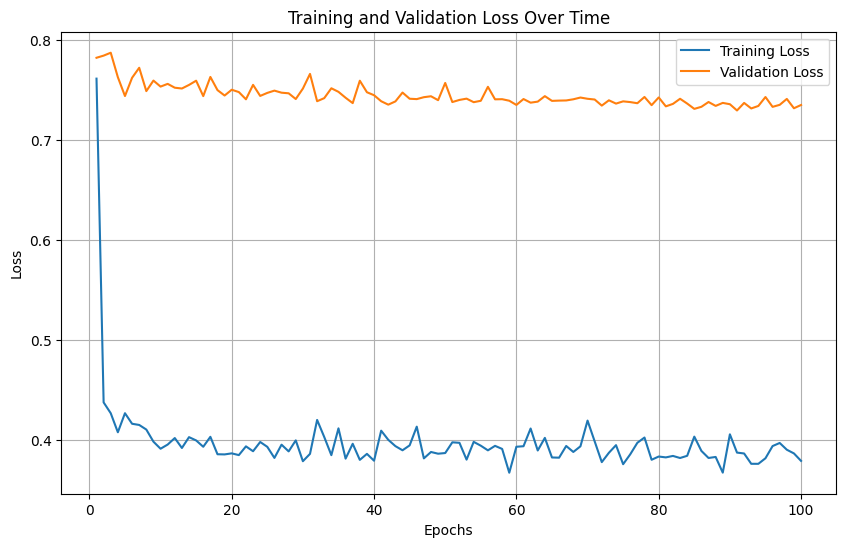

Loss plot saved to loss_plot.png


In [148]:
plot_loss(train_losses, val_losses, save_path='loss_plot.png')
